In [1]:
import pandas as pd
import numpy as np
from datetime import *
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests

In [2]:
df = pd.concat([pd.read_csv("data/lichess_swiss_rating_histories_1.csv",parse_dates=['date']),
                pd.read_csv("data/lichess_swiss_rating_histories_2.csv",parse_dates=['date'])])
print(df.shape)
df.head()

(8623368, 4)


,user_id,time_control,date,rating
0,0,Blitz,2019-01-04,2244
1,0,Blitz,2019-01-05,2256
2,0,Blitz,2019-01-06,2231
3,0,Blitz,2019-01-08,2307
4,0,Blitz,2019-01-29,2288


In [3]:
df['user_id'].nunique()

17171

In [4]:
df['date'].max()

Timestamp('2021-08-03 00:00:00')

In [5]:
# The latest date we have data on
max_outcome_date = df['date'].max()
# The latest date that can be used for training to ensure we'll always have 2 years in advance of outcomes data
max_training_date = max_outcome_date - timedelta(days=365*2)
max_outcome_date,max_training_date

(Timestamp('2021-08-03 00:00:00'), Timestamp('2019-08-04 00:00:00'))

In [6]:
# The earliest date we have data on
minn_training_date = df['date'].min()
minn_training_date

Timestamp('2019-01-01 00:00:00')

In [7]:
# The latest ratings that can be used for training
df_training = df.query('date<=@max_training_date')
df_outcomes = df.query('date>@max_training_date')
latest_training_ratings = df_training.sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
latest_training_ratings.sample(5)

,user_id,time_control,date,rating
564878,1286,Blitz,2019-07-28,1812
1679700,3869,Blitz,2019-04-18,1756
275233,10645,Classical,2019-05-27,1660
3046931,6743,Bullet,2019-05-31,1089
3656330,16784,Rapid,2019-04-30,1457


# Feature Engineering

In [8]:
# Ratings from X days before the max training date
max_training_date_minus_30 = max_training_date-timedelta(days=30)
max_training_date_minus_90 = max_training_date-timedelta(days=90)
max_training_date_minus_180 = max_training_date-timedelta(days=180)
hist_ratings_30 = df_training.query('date<=@max_training_date_minus_30').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_90 = df_training.query('date<=@max_training_date_minus_90').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180 = df_training.query('date<=@max_training_date_minus_180').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180.head()

,user_id,time_control,date,rating
7033,10091,Blitz,2019-02-05,1106
1488095,13023,Rapid,2019-02-05,1339
1475936,12996,Bullet,2019-02-05,1722
1476181,12996,Rapid,2019-02-05,1812
1476463,12997,Bullet,2019-02-05,1454


In [9]:
# Peak ratings
hist_ratings_peak = df_training.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
#outcome_ratings_peak = df_outcomes.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_peak.head()

,user_id,time_control,date,rating
3141002,6935,Bullet,2019-03-26,2872
4478689,9624,Bullet,2019-07-21,2852
2810666,6252,Bullet,2019-06-26,2847
4478286,9624,Blitz,2019-08-04,2833
3039334,6727,Bullet,2019-05-05,2832


In [10]:
# Rating volatility
rating_stdev_30 = df_training.query('date>=@max_training_date_minus_30').groupby(['user_id','time_control'])['rating'].std().fillna(0).reset_index().rename(columns={"rating":"rating_stdev_30"})
rating_stdev_90 = df_training.query('date>=@max_training_date_minus_90').groupby(['user_id','time_control'])['rating'].std().fillna(0).reset_index().rename(columns={"rating":"rating_stdev_90"})
rating_stdev_180 = df_training.query('date>=@max_training_date_minus_180').groupby(['user_id','time_control'])['rating'].std().fillna(0).reset_index().rename(columns={"rating":"rating_stdev_180"})
rating_stdev_30.head()

,user_id,time_control,rating_stdev_30
0,0,Blitz,8.502941
1,0,Bullet,31.096535
2,0,Rapid,0.000000
3,2,Blitz,24.794825
4,2,Rapid,16.867128


In [11]:
# Frequency of rating updates
rating_updates_30 = df_training.query('date>=@max_training_date_minus_30').groupby(['user_id','time_control']).size().reset_index().rename(columns={0:"rating_updates_30"})
rating_updates_90 = df_training.query('date>=@max_training_date_minus_90').groupby(['user_id','time_control']).size().reset_index().rename(columns={0:"rating_updates_90"})
rating_updates_90.head()

,user_id,time_control,rating_updates_90
0,0,Blitz,37
1,0,Bullet,56
2,0,Classical,4
3,0,Rapid,19
4,1,Blitz,8


In [12]:
# Non-target time control ratings
non_target_rating_updates_30 = rating_updates_30.pivot(index='user_id',columns='time_control',values='rating_updates_30').fillna(0)
non_target_rating_updates_30.columns = ['blitz_updates_30','bullet_updates_30','classical_updates_30','rapid_updates_30']
non_target_rating_updates_30.head()

,blitz_updates_30,bullet_updates_30,classical_updates_30,rapid_updates_30
user_id,,,,
0,5.0,14.0,0.0,2.0
2,16.0,0.0,0.0,8.0
3,28.0,1.0,4.0,0.0
4,3.0,3.0,1.0,0.0
6,14.0,0.0,0.0,0.0


In [13]:
# Add features to base table
df_base = latest_training_ratings.merge(hist_ratings_30[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_latest','_30']).merge(
            hist_ratings_90[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control']).merge(
            hist_ratings_180[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_90','_180']).merge(
            hist_ratings_peak[['user_id','time_control','rating']].rename(columns={'rating':'rating_peak'}),
                how='left',on=['user_id','time_control']).merge(
            rating_updates_30,how='left',on=['user_id','time_control']).merge(
            rating_updates_90,how='left',on=['user_id','time_control']).merge(
            rating_stdev_30,how='left',on=['user_id','time_control']).merge(
            rating_stdev_90,how='left',on=['user_id','time_control']).merge(
            rating_stdev_180,how='left',on=['user_id','time_control']).merge(
            non_target_rating_updates_30,how='left',on='user_id'
)
df_base['rating_30_diff'] = df_base['rating_latest']-df_base['rating_30']
df_base['rating_90_diff'] = (df_base['rating_latest']-df_base['rating_90']).combine_first(df_base['rating_30_diff'])
df_base['rating_180_diff'] = (df_base['rating_latest']-df_base['rating_180']).combine_first(df_base['rating_90_diff'])
df_base['rating_peak_diff'] = df_base['rating_latest']-df_base['rating_peak']
df_base['time_control_copy'] = df_base['time_control']
df_base['rating_latest_rounded'] = df_base['rating_latest'].round(-2)
df_base['rating_latest_squared'] = df_base['rating_latest']**2
df_base['rating_latest_rounded_200'] = 200*np.ceil(df_base['rating_latest_rounded']/200).astype(int)
df_base['rating_latest_rounded_300'] = 300*np.ceil(df_base['rating_latest_rounded']/300).astype(int)
df_base = pd.get_dummies(df_base,columns=['time_control_copy'],prefix_sep="")
df_base.columns = [x.replace("time_control_copy","").lower() for x in df_base.columns]
print(df_base.shape)
df_base.sample(10)

(41530, 29)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,rating_180_diff,rating_peak_diff,rating_latest_rounded,rating_latest_squared,rating_latest_rounded_200,rating_latest_rounded_300,blitz,bullet,classical,rapid
35065,3075,Bullet,2019-04-12,1552,1552.0,1552.0,NaN,1641,NaN,NaN,...,0.0,-89,1600,2408704,1600,1800,0,1,0,0
2582,4132,Blitz,2019-08-04,1857,1811.0,1790.0,NaN,1914,14.0,49.0,...,67.0,-57,1900,3448449,2000,2100,1,0,0,0
18620,10116,Classical,2019-07-22,1644,1598.0,1622.0,1594.0,1644,2.0,5.0,...,50.0,0,1600,2702736,1600,1800,0,0,1,0
465,11129,Blitz,2019-08-04,2008,1991.0,1834.0,1813.0,2064,8.0,20.0,...,195.0,-56,2000,4032064,2000,2100,1,0,0,0
26112,1276,Rapid,2019-06-24,1398,1398.0,1375.0,1343.0,1398,NaN,4.0,...,55.0,0,1400,1954404,1400,1500,0,0,0,1
41132,15747,Rapid,2019-01-08,1750,1750.0,1750.0,1750.0,1761,NaN,NaN,...,0.0,-11,1800,3062500,1800,1800,0,0,0,1
19800,14866,Classical,2019-07-19,1815,1783.0,1768.0,1732.0,1815,2.0,5.0,...,83.0,0,1800,3294225,1800,1800,0,0,1,0
29443,13802,Bullet,2019-06-03,1566,1566.0,NaN,NaN,1566,NaN,2.0,...,0.0,0,1600,2452356,1600,1800,0,1,0,0
3286,14407,Blitz,2019-08-04,1676,1614.0,1563.0,1626.0,1756,17.0,30.0,...,50.0,-80,1700,2808976,1800,1800,1,0,0,0
30936,15301,Rapid,2019-05-23,1682,1682.0,1683.0,1683.0,1683,NaN,2.0,...,-1.0,-1,1700,2829124,1800,1800,0,0,0,1


In [14]:
# Filter to people who have played rated games in the time control before 30 days ago...
# ... and have played at least one rated game in the time control within the last 30 days
df_base = df_base[(df_base['rating_30'].notna())&(df_base['date']>=max_training_date_minus_30)]
print(df_base.shape)
df_base.head()

(21641, 29)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,rating_180_diff,rating_peak_diff,rating_latest_rounded,rating_latest_squared,rating_latest_rounded_200,rating_latest_rounded_300,blitz,bullet,classical,rapid
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,19.0,49.0,...,60.0,-21,1600,2608225,1600,1800,1,0,0,0
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,30.0,90.0,...,185.0,0,1200,1478656,1200,1200,1,0,0,0
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,30.0,73.0,...,199.0,-165,1400,2053489,1400,1500,1,0,0,0
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,30.0,40.0,...,-2.0,-157,1600,2572816,1600,1800,0,1,0,0
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,21.0,51.0,...,-97.0,-97,1200,1336336,1200,1200,1,0,0,0


In [15]:
# What is the distribution of rating gains over the two year period?
## Use this to come up with reasonable target rating ranges where I'll have a decent sample size to work with when estimating how long it'll take
#df_max_rating_gains = df_base.merge(outcome_ratings_peak,on=['user_id','time_control'],how='inner')
#df_max_rating_gains['max_gain'] = df_max_rating_gains['rating']-df_max_rating_gains['rating_latest']
#df_max_rating_gains['rating_bucket'] = df_max_rating_gains['rating_latest'].apply(lambda x: 1 if x < 1550 else (2 if x < 1900 else 3))
#df_max_rating_gains.groupby("rating_bucket")['max_gain'].describe(percentiles=[.25,.5,.75,.9,.95,.99])

In [16]:
# Generate target ratings
df_targets = pd.concat([df_base for x in range(5)])
def get_target_rating_gain(x):
    die = np.random.randint(1,4)
    if die == 1:
        return np.random.randint(1,100)
    elif die == 2:
        return np.random.randint(1,300)
    elif die == 3:
        if x < 1550:
            return np.random.randint(1,650)
        elif x < 1900:
            return np.random.randint(1,450)
        else:
            return np.random.randint(1,350)
    else:
        print(1/0)

df_targets['target_rating_gain'] = df_targets['rating_latest'].apply(get_target_rating_gain)
df_targets['target_rating'] = df_targets['rating_latest'] + df_targets['target_rating_gain']
df_targets['target_rating_gain_rounded'] = df_targets['target_rating_gain'].round(-2)
df_targets['target_rating_gain_squared'] = df_targets['target_rating_gain']**2
print(df_targets.shape)
df_targets.head()

(108205, 33)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,rating_latest_rounded_200,rating_latest_rounded_300,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,19.0,49.0,...,1600,1800,1,0,0,0,79,1694,100,6241
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,30.0,90.0,...,1200,1200,1,0,0,0,156,1372,200,24336
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,30.0,73.0,...,1400,1500,1,0,0,0,199,1632,200,39601
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,30.0,40.0,...,1600,1800,0,1,0,0,168,1772,200,28224
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,21.0,51.0,...,1200,1200,1,0,0,0,99,1255,100,9801


In [17]:
df_targets.groupby("rating_latest_rounded")['target_rating_gain'].describe().round()

,count,mean,std,min,25%,50%,75%,max
rating_latest_rounded,,,,,,,,
600,20.0,173.0,150.0,21.0,65.0,132.0,219.0,586.0
700,30.0,194.0,173.0,4.0,62.0,160.0,243.0,627.0
800,460.0,174.0,167.0,1.0,46.0,102.0,262.0,642.0
900,1075.0,175.0,163.0,1.0,50.0,106.0,254.0,649.0
1000,2435.0,175.0,162.0,1.0,52.0,105.0,257.0,649.0
1100,3845.0,179.0,167.0,1.0,50.0,107.0,264.0,649.0
1200,5870.0,175.0,166.0,1.0,51.0,99.0,255.0,649.0
1300,6690.0,175.0,165.0,1.0,50.0,103.0,259.0,649.0
1400,9140.0,175.0,165.0,1.0,51.0,105.0,253.0,649.0


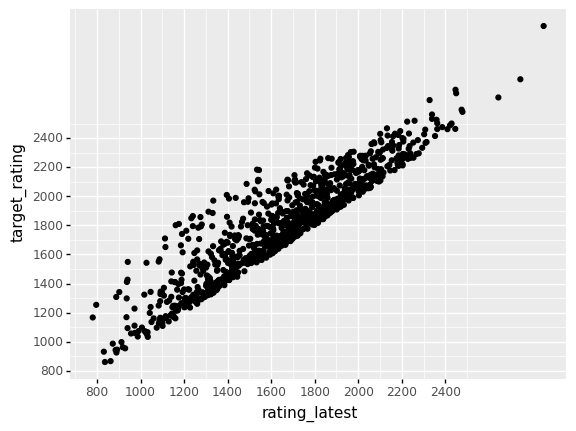

<ggplot: (8768024148270)>

In [18]:
(ggplot(df_targets.sample(1000),aes(x='rating_latest',y='target_rating')) +
 geom_point() +
 scale_x_continuous(breaks=list(range(800,2500,200))) +
  scale_y_continuous(breaks=list(range(800,2500,200)))

        
       )

In [19]:
df_temp = df_targets.copy()
df_temp = df_temp.merge(df_outcomes,on=['user_id','time_control'],how='outer',suffixes=['_latest','_future'])
df_temp.head()

,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,rating
0,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,19.0,49.0,...,1.0,0.0,0.0,0.0,79.0,1694.0,100.0,6241.0,2019-08-05,1598.0
1,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,19.0,49.0,...,1.0,0.0,0.0,0.0,79.0,1694.0,100.0,6241.0,2019-08-06,1630.0
2,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,19.0,49.0,...,1.0,0.0,0.0,0.0,79.0,1694.0,100.0,6241.0,2019-08-07,1626.0
3,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,19.0,49.0,...,1.0,0.0,0.0,0.0,79.0,1694.0,100.0,6241.0,2019-08-08,1654.0
4,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,19.0,49.0,...,1.0,0.0,0.0,0.0,79.0,1694.0,100.0,6241.0,2019-08-09,1644.0


In [20]:
# Successes - filter to where future rating >= target rating, then take earliest date for each user/time control
df_successes = df_temp.query('rating>=target_rating').sort_values("date_future").drop_duplicates(['user_id','time_control','target_rating'])
print(df_successes.shape)
df_successes.sample(5)

(80849, 35)


,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,rating
7502230,7500,Bullet,2019-08-04,2278.0,2238.0,2157.0,2052.0,2302.0,18.0,63.0,...,0.0,1.0,0.0,0.0,107.0,2385.0,100.0,11449.0,2019-11-08,2402.0
7600445,7494,Rapid,2019-08-04,1326.0,1317.0,NaN,NaN,1680.0,16.0,43.0,...,0.0,0.0,0.0,1.0,1.0,1327.0,0.0,1.0,2019-08-16,1349.0
13454101,8484,Bullet,2019-08-02,1248.0,1297.0,NaN,NaN,1319.0,3.0,4.0,...,0.0,1.0,0.0,0.0,78.0,1326.0,100.0,6084.0,2020-10-18,1404.0
3278684,9090,Bullet,2019-08-04,1135.0,1114.0,NaN,NaN,1304.0,14.0,18.0,...,0.0,1.0,0.0,0.0,246.0,1381.0,200.0,60516.0,2020-04-28,1426.0
8003508,4870,Rapid,2019-08-04,1026.0,1043.0,1296.0,NaN,1329.0,5.0,9.0,...,0.0,0.0,0.0,1.0,98.0,1124.0,100.0,9604.0,2020-04-19,1135.0


In [21]:
# Successes and failures 
df_bin = df_targets.merge(df_successes[['user_id','time_control','target_rating','date_future']],on=['user_id','time_control','target_rating'],how='left')
# Was the target rating achieved?
df_bin['y_bin'] = df_bin['date_future'].notna().astype(int)
# If so, when?
df_bin['y_cont'] = (df_bin['date_future']-max_training_date).dt.days
print(df_bin.shape)
df_bin.sample(10)

(108205, 36)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_updates_30,rating_updates_90,...,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,y_bin,y_cont
50913,14122,Bullet,2019-08-03,1506,1513.0,1508.0,1565.0,1596,2.0,4.0,...,1,0,0,60,1566,100,3600,2019-08-11,1,7.0
41162,9127,Rapid,2019-07-14,1449,1323.0,1323.0,NaN,1449,1.0,1.0,...,0,0,1,281,1730,300,78961,NaT,0,NaN
103591,15226,Rapid,2019-07-22,1820,1824.0,1969.0,1769.0,1969,1.0,25.0,...,0,0,1,283,2103,300,80089,2021-03-09,1,583.0
46191,16248,Classical,2019-08-04,1864,1824.0,1782.0,1540.0,1881,21.0,60.0,...,0,1,0,113,1977,100,12769,2020-07-05,1,336.0
88935,16045,Blitz,2019-08-04,2039,2092.0,1990.0,2038.0,2108,27.0,77.0,...,0,0,0,11,2050,0,121,2019-08-05,1,1.0
84674,1032,Rapid,2019-07-13,1118,1130.0,1130.0,1035.0,1204,2.0,2.0,...,0,0,1,39,1157,0,1521,2020-11-13,1,467.0
29817,12077,Blitz,2019-08-03,2132,2092.0,2075.0,NaN,2158,20.0,67.0,...,0,0,0,38,2170,0,1444,2019-08-17,1,13.0
67599,14834,Rapid,2019-08-04,1160,1201.0,953.0,1187.0,1208,6.0,37.0,...,0,0,1,60,1220,100,3600,2020-08-02,1,364.0
87690,9763,Blitz,2019-08-04,2210,2195.0,2124.0,2226.0,2264,8.0,28.0,...,0,0,0,199,2409,200,39601,NaT,0,NaN
9751,9810,Classical,2019-08-02,1421,1440.0,1432.0,1553.0,1575,2.0,5.0,...,0,1,0,205,1626,200,42025,2020-11-01,1,455.0


In [22]:
df_cont = df_bin[df_bin['y_bin']==1].copy()

# EDA

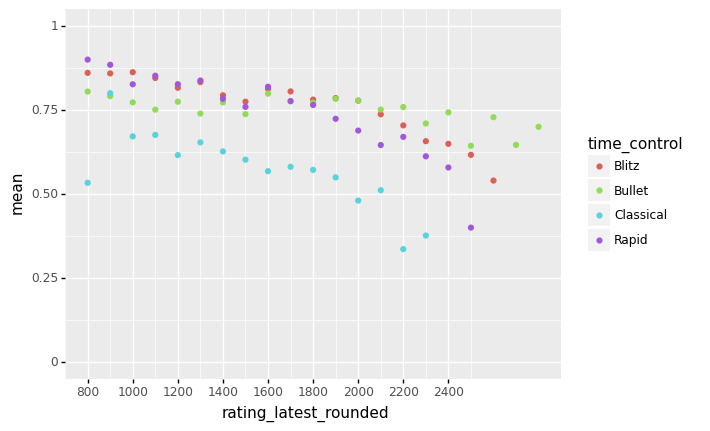

<ggplot: (8767923696002)>

In [23]:
y_bin_by_rating = df_bin.groupby(["rating_latest_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_by_rating[y_bin_by_rating['len']>=25].reset_index(),
        aes(x='rating_latest_rounded',y='mean',color='time_control')) +
 geom_point() +
      scale_x_continuous(breaks=list(range(600,2600,200))) +
         ylim([0,1])
       )

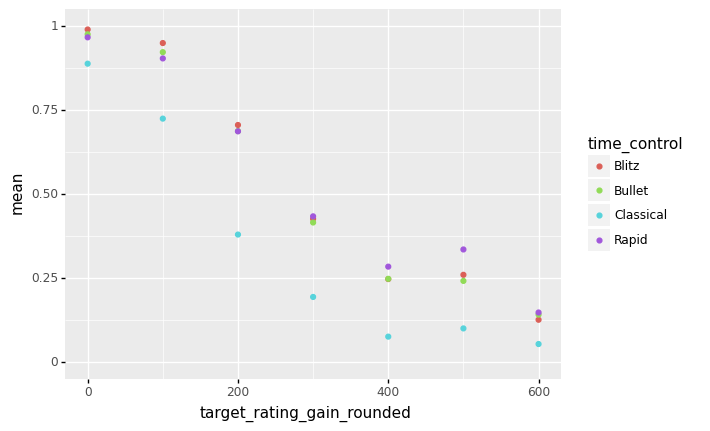

<ggplot: (8768024145619)>

In [24]:
y_bin_by_gain = df_bin.groupby(["target_rating_gain_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_by_gain[y_bin_by_gain['len']>=25].reset_index(),
        aes(x='target_rating_gain_rounded',y='mean',color='time_control')) +
 geom_point() +
         ylim([0,1])
       )

In [25]:
bin_by_quant_vars = df_bin.groupby(['target_rating_gain_rounded','rating_latest_rounded'])['y_bin'].mean().reset_index().round(2)
bin_by_quant_vars.pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='y_bin').iloc[:-2,6:-7]

rating_latest_rounded,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200
target_rating_gain_rounded,,,,,,,,,,,
0,0.96,0.97,0.96,0.97,0.97,0.97,0.98,0.97,0.96,0.97,0.97
100,0.92,0.94,0.93,0.93,0.91,0.92,0.91,0.90,0.88,0.87,0.87
200,0.79,0.80,0.75,0.74,0.72,0.66,0.67,0.58,0.56,0.46,0.49
300,0.63,0.65,0.59,0.51,0.43,0.40,0.35,0.28,0.22,0.17,0.14
400,0.45,0.38,0.34,0.25,0.18,0.15,0.12,0.05,NaN,NaN,NaN


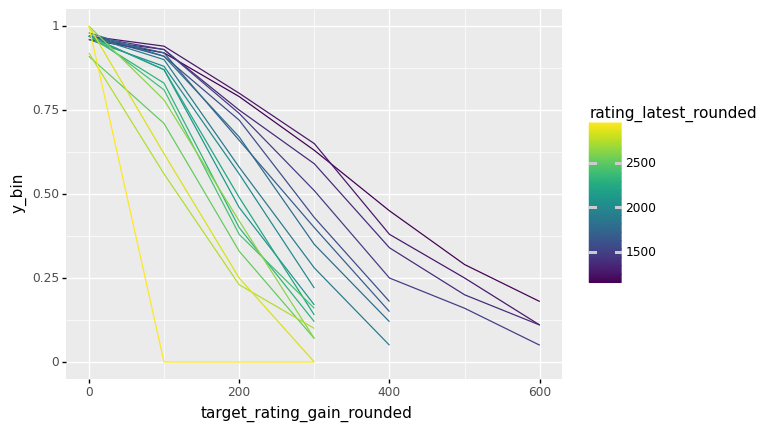

<ggplot: (8767923696113)>

In [26]:
(ggplot(bin_by_quant_vars.query("rating_latest_rounded>=1200"),aes(x='target_rating_gain_rounded',y='y_bin',group='rating_latest_rounded',
       color='rating_latest_rounded')) +
geom_line())

As target rating gain increases, the effect of latest rating should go from zero to more negative.

In [27]:
mean_days_by_quant_vars = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded'])['y_cont'].mean().reset_index().round()
mean_days_by_quant_vars.pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='y_cont').iloc[:-1,6:-6]

rating_latest_rounded,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
target_rating_gain_rounded,,,,,,,,,,,,
0,114.0,105.0,98.0,91.0,87.0,93.0,87.0,85.0,88.0,91.0,102.0,80.0
100,182.0,172.0,169.0,167.0,173.0,174.0,173.0,175.0,183.0,193.0,178.0,177.0
200,283.0,279.0,289.0,282.0,303.0,320.0,320.0,331.0,338.0,327.0,345.0,319.0
300,337.0,347.0,376.0,366.0,392.0,427.0,427.0,450.0,446.0,436.0,461.0,394.0
400,426.0,437.0,413.0,459.0,467.0,524.0,499.0,549.0,NaN,NaN,NaN,NaN
500,451.0,466.0,516.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
mean_days_by_quant_vars.head()

,target_rating_gain_rounded,rating_latest_rounded,y_cont
0,0,600,15.0
1,0,700,42.0
2,0,800,127.0
3,0,900,135.0
4,0,1000,122.0


In [29]:
y_cont_by_rating = df_cont.groupby(["rating_latest_rounded",'time_control'])['y_cont'].agg([np.mean,len]).reset_index()
y_cont_by_rating.head()

,rating_latest_rounded,time_control,mean,len
0,600,Blitz,27.200000,10.0
1,600,Bullet,75.000000,5.0
2,600,Rapid,243.800000,5.0
3,700,Blitz,124.066667,15.0
4,700,Bullet,669.000000,1.0


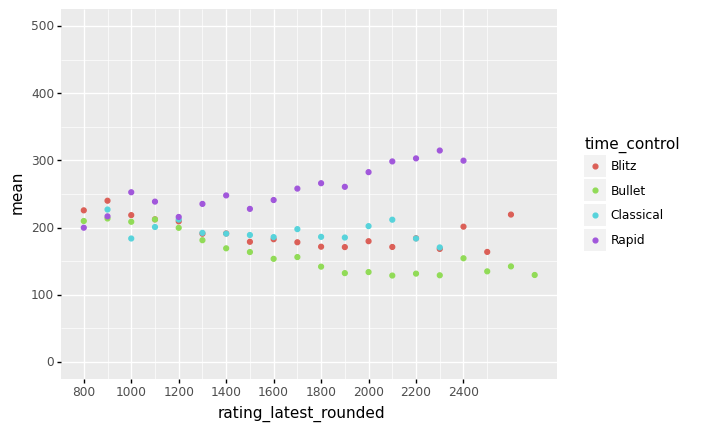

<ggplot: (8766113759501)>

In [30]:
(ggplot(y_cont_by_rating.query('len>=25'),aes(x='rating_latest_rounded',y='mean',color='time_control')) +
        geom_point() +
    ylim(0,500) +
     scale_x_continuous(breaks=list(range(600,2600,200)))
        
       )

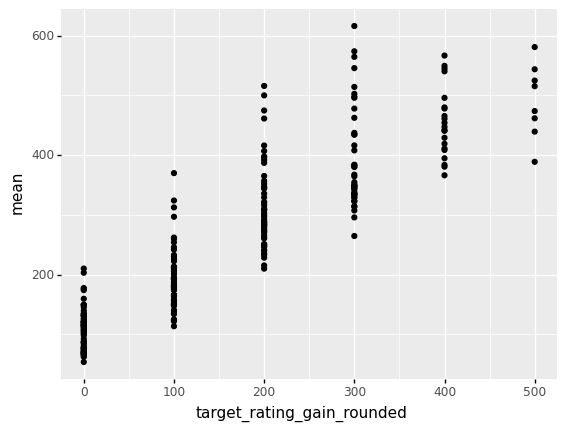

<ggplot: (8766113964614)>

In [31]:
mean_outcome_by_group = df_cont.groupby(['target_rating_gain_rounded','time_control','rating_latest_rounded'])['y_cont'].agg([np.mean,len]).reset_index()
(ggplot(mean_outcome_by_group.query('len>=30'),aes(x='target_rating_gain_rounded',y='mean')) +
      geom_point())

In [32]:
# Outlier checks
## High gains
df_cont['target_rating_gain'].describe(percentiles=[x/10 for x in range(10)])

count    81502.000000
mean       106.317293
std         96.261585
min          1.000000
0%           1.000000
10%         15.000000
20%         30.000000
30%         46.000000
40%         61.000000
50%         77.000000
60%         93.000000
70%        126.000000
80%        178.000000
90%        244.000000
max        649.000000
Name: target_rating_gain, dtype: float64

In [33]:
## Quick gains
df_cont[df_cont['target_rating_gain']>100]['y_cont'].describe(percentiles=[x/10 for x in range(10)])

count    28905.000000
mean       308.077945
std        208.043352
min          1.000000
0%           1.000000
10%         66.000000
20%        109.000000
30%        152.000000
40%        206.000000
50%        254.000000
60%        324.000000
70%        440.000000
80%        541.000000
90%        629.000000
max        730.000000
Name: y_cont, dtype: float64

## Identify Fast-improvers

In [34]:
df_cont['fast_improver'] = (df_cont['y_cont']<34).astype(int)
df_cont.groupby("fast_improver")['rating_30_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
fast_improver,,,,,,,,
0,61522.0,14.179367,69.804183,-459.0,-20.0,7.0,43.0,777.0
1,19980.0,8.928078,78.476140,-459.0,-34.0,4.0,48.0,777.0


In [35]:
df_cont.groupby(["fast_improver","time_control"])['rating_updates_30'].describe()

count       mean       std  min  25%   50%  \
fast_improver time_control                                                 
0             Blitz         24918.0  10.251987  8.803156  1.0  3.0   7.0   
              Bullet        17218.0   8.776455  8.266101  1.0  2.0   6.0   
              Classical      5563.0   5.252921  5.730071  1.0  1.0   3.0   
              Rapid         13823.0   6.903277  7.163710  1.0  2.0   4.0   
1             Blitz          9042.0  15.090577  9.341491  1.0  7.0  15.0   
              Bullet         6567.0  13.952033  9.383444  1.0  5.0  13.0   
              Classical      1530.0   8.073856  7.915622  1.0  2.0   5.0   
              Rapid          2841.0  10.652587  8.688063  1.0  3.0   8.0   

                             75%   max  
fast_improver time_control              
0             Blitz         16.0  31.0  
              Bullet        14.0  31.0  
              Classical      7.0  31.0  
              Rapid         10.0  31.0  
1             Blitz         23.0  31.0  
              Bullet        22.0  31.0  
              Classical     12.0  31.0  
              Rapid         17.0  31.0

## Non-target ratings

In [36]:
df_cont[['y_cont','rating_updates_30','blitz_updates_30','bullet_updates_30','rapid_updates_30','classical_updates_30']].corr()

,y_cont,rating_updates_30,blitz_updates_30,bullet_updates_30,rapid_updates_30,classical_updates_30
y_cont,1.000000,-0.196375,-0.090068,-0.097267,0.002789,-0.014285
rating_updates_30,-0.196375,1.000000,0.460885,0.347594,0.173777,0.046716
blitz_updates_30,-0.090068,0.460885,1.000000,0.151304,0.086389,-0.002743
bullet_updates_30,-0.097267,0.347594,0.151304,1.000000,-0.038367,-0.040061
rapid_updates_30,0.002789,0.173777,0.086389,-0.038367,1.000000,0.194889
classical_updates_30,-0.014285,0.046716,-0.002743,-0.040061,0.194889,1.000000


# Modeling

In [116]:
logit = smf.logit(formula="""
y_bin~target_rating_gain*rating_latest*bullet+target_rating_gain*rating_latest*blitz+
target_rating_gain*rating_latest*classical+

target_rating_gain_squared*rating_latest+

rating_peak_diff*target_rating_gain+rating_180_diff*bullet+rating_180_diff*blitz+

rating_updates_30+

rating_updates_90*bullet+rating_updates_90*blitz+

rating_stdev_90
""",data=df_bin).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.339841
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_bin   No. Observations:               108205
Model:                          Logit   Df Residuals:                   108177
Method:                           MLE   Df Model:                           27
Date:                Thu, 05 Aug 2021   Pseudo R-squ.:                  0.3918
Time:                        22:02:33   Log-Likelihood:                -36773.
converged:                       True   LL-Null:                       -60462.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      4.8376      0.269     17.963      0.000       4.310       5.366
target_rating_gain                             0.0005      0.001      0.348      0.728      -0.002       0.003
rating_latest                                 -0.0008      0.000     -5.216      0.000      -0.001      -0.001
target_rating_gain:rating_latest           -1.105e-05   9.02e-07    -12.255      0.000   -1.28e-05   -9.28e-06
bullet                                        -3.8037      0.289    -13.163      0.000      -4.370      -3.237
target_rating_gain:bullet                      0.0053      0.001      5.003      0.000       0.003       0.007
rating_latest:bullet                           0.0024      0.000     14.063      0.000       0.002       0.003
target_rating_gain:rating_latest:bullet    -3.824e-06   6.85e-07     -5.582      0.000   -5.17e-06   -2.48e-06
blitz                                         -0.2717      0.304     -0.892      0.372      -0.869       0.325
target_rating_gain:blitz                       0.0002      0.001      0.194      0.846      -0.002       0.002
rating_latest:blitz                            0.0009      0.000      4.962      0.000       0.001       0.001
target_rating_gain:rating_latest:blitz      -1.98e-06   6.79e-07     -2.917      0.004   -3.31e-06   -6.49e-07
classical                                     -3.1601      0.333     -9.492      0.000      -3.813      -2.508
target_rating_gain:classical                   0.0059      0.001      4.282      0.000       0.003       0.009
rating_latest:classical                        0.0011      0.000      5.542      0.000       0.001       0.001
target_rating_gain:rating_latest:classical -3.859e-06   8.98e-07     -4.296      0.000   -5.62e-06    -2.1e-06
target_rating_gain_squared                  -7.54e-06   2.24e-06     -3.373      0.001   -1.19e-05   -3.16e-06
target_rating_gain_squared:rating_latest    1.201e-08   1.53e-09      7.868      0.000    9.01e-09     1.5e-08
rating_peak_diff                              -0.0048      0.000    -16.214      0.000      -0.005      -0.004
rating_peak_diff:target_rating_gain         7.048e-06   9.27e-07      7.604      0.000    5.23e-06    8.86e-06
rating_180_diff                                0.0016      0.000     10.159      0.000       0.001       0.002
rating_180_diff:bullet                        -0.0013      0.000     -6.402      0.000      -0.002      -0.001
rating_180_diff:blitz                         -0.0020      0.000     -9.667      0.000      -0.002      -0.002
rating_updates_30                              0.0103      0.002      4.543      0.000       0.006       0.015
rating_updates_90                              0.0070      0.001      6.024      0.000       0.005       0.009
rating_updates_90:bullet                      -0.0052      0.001     -4.407      0.000      -0.008      -0.003
rating_updates_90:blit

In [117]:
# Regression
ols = smf.ols(formula="""
y_cont~
target_rating_gain*rating_latest*bullet+target_rating_gain*rating_latest*blitz+target_rating_gain*rating_latest*classical+
target_rating_gain_squared*bullet+target_rating_gain_squared*blitz+
rating_latest_squared+

rating_peak_diff*bullet+rating_peak_diff*blitz+
rating_peak_diff*target_rating_gain+

rating_180_diff*bullet+rating_180_diff*blitz+

rating_90_diff+

rating_30_diff*bullet+rating_30_diff*classical+

rating_updates_30+rating_updates_90*blitz+rating_updates_90*classical+

rating_stdev_30

""",data=df_cont).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_cont   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     1344.
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        22:02:34   Log-Likelihood:            -5.2698e+05
No. Observations:               81502   AIC:                         1.054e+06
Df Residuals:                   81466   BIC:                         1.054e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    326.7334     15.802     20.677      0.000     295.762     357.705
target_rating_gain                             0.2869      0.088      3.272      0.001       0.115       0.459
rating_latest                                 -0.2656      0.015    -17.590      0.000      -0.295      -0.236
target_rating_gain:rating_latest               0.0009   4.62e-05     19.907      0.000       0.001       0.001
bullet                                       127.1653     13.615      9.340      0.000     100.480     153.850
target_rating_gain:bullet                      0.3588      0.108      3.323      0.001       0.147       0.570
rating_latest:bullet                          -0.0885      0.008    -11.462      0.000      -0.104      -0.073
target_rating_gain:rating_latest:bullet       -0.0006   5.57e-05    -11.557      0.000      -0.001      -0.001
blitz                                        114.6478     13.303      8.618      0.000      88.574     140.722
target_rating_gain:blitz                      -0.0179      0.105     -0.171      0.864      -0.223       0.187
rating_latest:blitz                           -0.0942      0.008    -12.490      0.000      -0.109      -0.079
target_rating_gain:rating_latest:blitz        -0.0001   5.44e-05     -2.641      0.008      -0.000    -3.7e-05
classical                                     15.8346     18.424      0.859      0.390     -20.277      51.946
target_rating_gain:classical                   0.4571      0.133      3.424      0.001       0.195       0.719
rating_latest:classical                       -0.0103      0.011     -0.915      0.360      -0.032       0.012
target_rating_gain:rating_latest:classical    -0.0005   8.84e-05     -5.243      0.000      -0.001      -0.000
target_rating_gain_squared                    -0.0014   7.54e-05    -17.973      0.000      -0.002      -0.001
target_rating_gain_squared:bullet              0.0008      0.000      7.693      0.000       0.001       0.001
target_rating_gain_squared:blitz               0.0006   9.83e-05      6.071      0.000       0.000       0.001
rating_latest_squared                       8.772e-05    4.1e-06     21.415      0.000    7.97e-05    9.57e-05
rating_peak_diff                               0.1777      0.018     10.105      0.000       0.143       0.212
rating_peak_diff:bullet                        0.0847      0.021      3.993      0.000       0.043       0.126
rating_peak_diff:blitz                         0.0759      0.020      3.724      0.000       0.036       0.116
rating_peak_diff:target_rating_gain         1.032e-05   6.16e-05      0.167      0.867      -0.000       0.000
rating_180_diff                               -0.0819      0.012     -6.994      0.000

In [118]:
ols.get_prediction(df_cont).summary_frame().head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,146.749043,1.826073,143.169952,150.328135,-158.216962,451.715048
1,225.654146,3.486323,218.820977,232.487315,-79.367405,530.675697
2,208.500256,3.139792,202.346285,214.654226,-96.506836,513.507347
3,147.447271,2.824415,141.911438,152.983105,-157.547974,452.442517
4,-3.606362,2.801960,-9.098184,1.885459,-308.600812,301.388088


# Evaluation

## Classification Evaluation

In [119]:
df_bin['prob'] = logit.predict(df_bin)
df_bin['prob'].describe()

count    108205.000000
mean          0.753218
std           0.283471
min           0.010297
25%           0.593312
50%           0.901186
75%           0.968856
max           0.999794
Name: prob, dtype: float64

In [120]:
print(round(df_bin['prob'].mean(),3))
print(round(df_bin['y_bin'].mean(),3))

0.753
0.753


In [121]:
round(((df_bin['prob']-df_bin['y_bin'])**2).mean(),3)

0.106

In [122]:
for x in df_bin['time_control'].unique():
    data = df_bin.query("time_control==@x")
    print(x)
    print(round(((data['prob']-data['y_bin'])**2).mean(),3))

Blitz
0.089
Bullet
0.108
Classical
0.151
Rapid
0.111


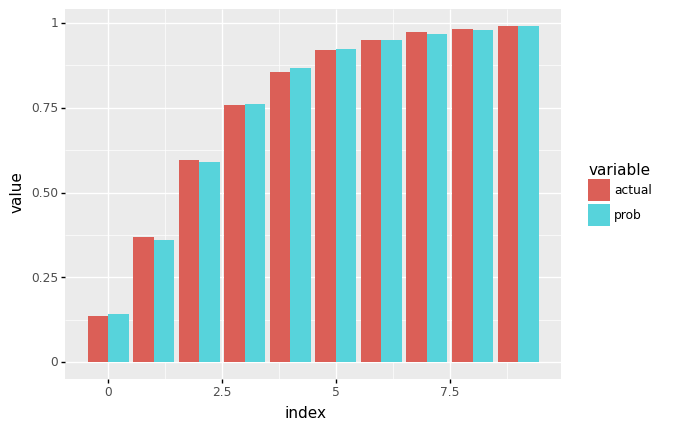

<ggplot: (8766113457399)>

In [123]:
df_bin['decile'] = pd.qcut(df_bin['prob'],q=10)
deciles = df_bin.groupby('decile')[['prob','y_bin']].mean().reset_index()
deciles['index'] = np.arange(len(deciles))
decile_probs = deciles[['prob','index']].rename(columns={"prob":"value"})
decile_probs['variable'] = 'prob'
decile_actuals = deciles[['y_bin','index']].rename(columns={"y_bin":"value"})
decile_actuals['variable'] = 'actual'
deciles = pd.concat([decile_probs,decile_actuals],axis=0)
(ggplot(deciles,aes(x='index',y='value',fill='variable')) +
 geom_bar(stat='identity',position='dodge')
)

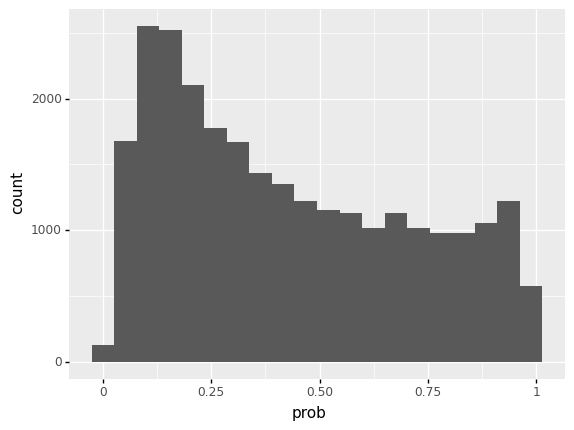

<ggplot: (8767993832976)>

In [124]:
(ggplot(df_bin.query('y_bin==0'),aes(x='prob')) +
geom_histogram(bins=20))

In [125]:
# Identify the ones with high-prob that are zeros (where we're overpredicting)
df_bin.query("prob>=.75&y_bin==0").groupby(["time_control","rating_latest_rounded_300","target_rating_gain_rounded"]).size().sort_values(ascending=False).head(10)

time_control  rating_latest_rounded_300  target_rating_gain_rounded
Rapid         1800                       100                           235
Blitz         2100                       100                           218
Rapid         2100                       100                           214
Blitz         1500                       200                           213
              1800                       200                           209
                                         100                           195
Bullet        1800                       100                           193
              1500                       100                           187
              2100                       100                           162
Classical     1800                       100                           153
dtype: int64

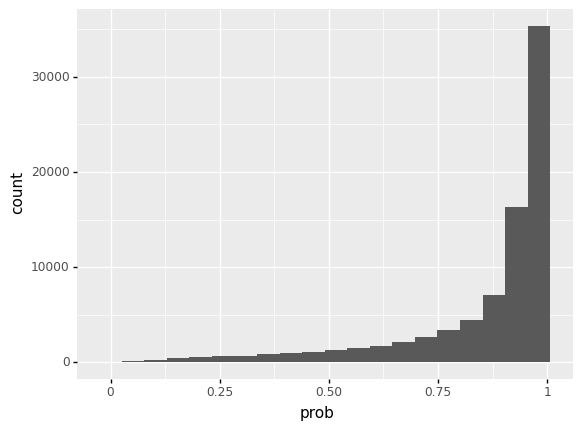

<ggplot: (8766114487679)>

In [126]:
(ggplot(df_bin.query('y_bin==1'),aes(x='prob')) +
geom_histogram(bins=20))

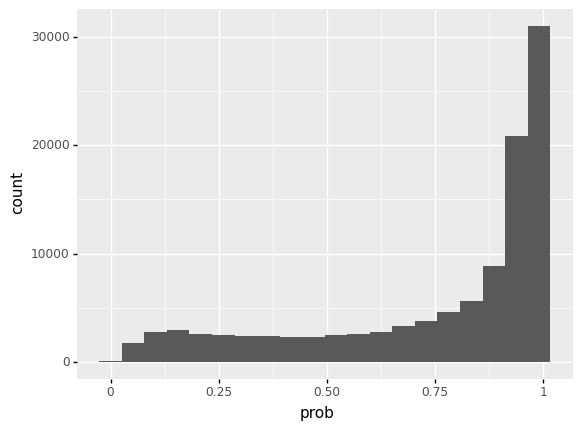

<ggplot: (8766113452599)>

In [127]:
(ggplot(df_bin,aes(x='prob')) +
geom_histogram(bins=20))

In [128]:

xtabs_bin = df_bin.groupby(['time_control','target_rating_gain_rounded','rating_latest_rounded_300'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)
xtabs_bin.columns = ['prop_actual','n','mean_prob']
xtabs_bin.reset_index(inplace=True)
xtabs_bin['diff'] = xtabs_bin['mean_prob'] - xtabs_bin['prop_actual']
xtabs_bin['abs_diff'] = xtabs_bin['diff'].abs()
xtabs_bin.query("n>=50").sort_values("abs_diff",ascending=False).head(10)

,time_control,target_rating_gain_rounded,rating_latest_rounded_300,prop_actual,n,mean_prob,diff,abs_diff
103,Classical,100,2400,0.36,85,0.59,0.23,0.23
60,Bullet,100,2700,0.75,129,0.93,0.18,0.18
15,Blitz,100,2700,0.70,92,0.87,0.17,0.17
26,Blitz,300,900,0.79,62,0.91,0.12,0.12
114,Classical,300,1500,0.39,300,0.27,-0.12,0.12
71,Bullet,300,900,0.65,75,0.76,0.11,0.11
106,Classical,200,1200,0.54,151,0.64,0.10,0.10
27,Blitz,300,1200,0.70,538,0.79,0.09,0.09
163,Rapid,400,2100,0.05,97,0.13,0.08,0.08
83,Bullet,400,2100,0.04,69,0.12,0.08,0.08


In [129]:
df_bin.groupby(['rating_latest_rounded_200'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)


y_bin         prob
                           mean    len  mean
rating_latest_rounded_200                   
600                        1.00     20  0.97
800                        0.80    490  0.88
1000                       0.81   3510  0.85
1200                       0.79   9715  0.81
1400                       0.77  15830  0.77
1600                       0.76  23355  0.75
1800                       0.76  24205  0.74
2000                       0.74  18830  0.74
2200                       0.71   8855  0.72
2400                       0.67   2720  0.71
2600                       0.62    560  0.72
2800                       0.57    110  0.74
3000                       0.40      5  0.56

In [130]:
df_bin.groupby(['target_rating_gain_rounded'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)


y_bin         prob
                            mean    len  mean
target_rating_gain_rounded                   
0                           0.97  27925  0.97
100                         0.91  37229  0.91
200                         0.66  20163  0.66
300                         0.40  13420  0.40
400                         0.23   5311  0.24
500                         0.25   2069  0.22
600                         0.13   2088  0.14

In [131]:
xtabs_bin.query("time_control=='Classical'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_300',values='prop_actual').iloc[:,1:-1]

rating_latest_rounded_300,1200,1500,1800,2100,2400
target_rating_gain_rounded,,,,,
0,0.87,0.89,0.91,0.86,0.82
100,0.80,0.79,0.73,0.65,0.36
200,0.54,0.54,0.36,0.22,0.11
300,0.50,0.39,0.15,0.05,0.00
400,0.27,0.15,0.02,0.00,NaN
500,0.18,0.05,NaN,NaN,NaN
600,0.08,0.04,NaN,NaN,NaN


In [132]:
xtabs_bin.query("time_control=='Classical'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_300',values='mean_prob').iloc[:,1:-1]

rating_latest_rounded_300,1200,1500,1800,2100,2400
target_rating_gain_rounded,,,,,
0,0.91,0.90,0.89,0.88,0.88
100,0.84,0.78,0.72,0.66,0.59
200,0.64,0.49,0.33,0.22,0.13
300,0.47,0.27,0.15,0.07,0.03
400,0.29,0.13,0.06,0.03,NaN
500,0.19,0.07,NaN,NaN,NaN
600,0.13,0.05,NaN,NaN,NaN


In [133]:
xtabs_bin.query("time_control=='Classical'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_300',values='diff').iloc[:,1:-1]

rating_latest_rounded_300,1200,1500,1800,2100,2400
target_rating_gain_rounded,,,,,
0,0.04,0.01,-0.02,0.02,0.06
100,0.04,-0.01,-0.01,0.01,0.23
200,0.10,-0.05,-0.03,0.00,0.02
300,-0.03,-0.12,0.00,0.02,0.03
400,0.02,-0.02,0.04,0.03,NaN
500,0.01,0.02,NaN,NaN,NaN
600,0.05,0.01,NaN,NaN,NaN


In [134]:
xtabs_bin.query("time_control=='Classical'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_300',values='n').iloc[:,1:-1]

rating_latest_rounded_300,1200,1500,1800,2100,2400
target_rating_gain_rounded,,,,,
0,280.0,757.0,1340.0,692.0,55.0
100,352.0,1037.0,1708.0,1002.0,85.0
200,151.0,543.0,947.0,522.0,54.0
300,101.0,300.0,690.0,372.0,31.0
400,51.0,166.0,375.0,62.0,NaN
500,71.0,152.0,NaN,NaN,NaN
600,64.0,170.0,NaN,NaN,NaN


## Regression Evaluation

In [135]:
df_cont['pred'] = ols.predict(df_cont)
#df_cont.loc[df_cont['pred']<0,'pred'] = 0
df_cont['pred'].describe()

count    81502.000000
mean       191.597016
std        118.185525
min       -186.557882
25%        108.337176
50%        168.966568
75%        257.365885
max        788.247131
Name: pred, dtype: float64

In [136]:
len(df_cont[df_cont['pred']<0])/len(df_cont)

0.01655174106156904

In [137]:
df_cont['error'] = df_cont['pred']-df_cont['y_cont']
df_cont['abs_error'] = df_cont['error'].abs()

In [138]:
df_cont['error'].describe().round()

count    81502.0
mean         0.0
std        156.0
min       -702.0
25%        -61.0
50%         36.0
75%         99.0
max        568.0
Name: error, dtype: float64

In [139]:
df_cont['abs_error'].describe().round()

count    81502.0
mean       117.0
std        103.0
min          0.0
25%         43.0
50%         89.0
75%        155.0
max        702.0
Name: abs_error, dtype: float64

In [140]:
error_summary = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control'])[['pred','y_cont','abs_error','error']].agg([np.mean]).round().astype(int)
sizes = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control']).size().reset_index()
sizes.rename(columns={0:"n"},inplace=True)
error_summary.columns = ['mean_pred','mean_actual','mean_abs_error','mean_error']
error_summary = error_summary.reset_index().merge(sizes,on=['target_rating_gain_rounded','rating_latest_rounded','time_control'])
error_summary = error_summary.query('n>30')
error_summary.sort_values("mean_error",ascending=False).head(10)

,target_rating_gain_rounded,rating_latest_rounded,time_control,mean_pred,mean_actual,mean_abs_error,mean_error,n
335,400,1400,Rapid,490,419,127,71,37
293,300,2100,Bullet,326,265,182,61,51
340,400,1600,Blitz,520,466,135,54,76
381,500,1500,Blitz,574,525,115,49,33
259,300,1200,Rapid,378,329,149,48,69
270,300,1500,Classical,380,336,159,44,46
373,500,1300,Blitz,503,462,117,41,32
8,0,900,Bullet,153,115,113,38,106
180,200,1100,Rapid,299,260,150,38,82
271,300,1500,Rapid,445,408,144,37,139


In [62]:
df_cont.groupby("time_control")['abs_error'].mean().round()

time_control
Blitz        114.0
Bullet       108.0
Classical    124.0
Rapid        133.0
Name: abs_error, dtype: float64

In [63]:
error_summary.query("time_control=='Rapid'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='mean_actual')

rating_latest_rounded,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
target_rating_gain_rounded,,,,,,,,,,,,,,,
0,149.0,149.0,177.0,118.0,122.0,126.0,118.0,113.0,132.0,134.0,131.0,149.0,174.0,203.0,210.0
100,201.0,246.0,206.0,174.0,192.0,226.0,193.0,230.0,242.0,254.0,262.0,297.0,312.0,324.0,370.0
200,NaN,329.0,260.0,284.0,321.0,352.0,336.0,365.0,407.0,416.0,461.0,475.0,500.0,516.0,NaN
300,NaN,349.0,367.0,329.0,384.0,435.0,408.0,463.0,503.0,514.0,546.0,565.0,NaN,NaN,NaN
400,NaN,NaN,NaN,411.0,478.0,419.0,496.0,540.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN
500,NaN,NaN,NaN,NaN,515.0,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
error_summary.query("time_control=='Rapid'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='mean_pred')

rating_latest_rounded,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
target_rating_gain_rounded,,,,,,,,,,,,,,,
0,126.0,128.0,127.0,120.0,119.0,119.0,123.0,122.0,132.0,142.0,147.0,162.0,178.0,189.0,202.0
100,179.0,187.0,196.0,197.0,201.0,210.0,212.0,224.0,238.0,249.0,258.0,279.0,304.0,316.0,344.0
200,NaN,288.0,298.0,310.0,322.0,340.0,353.0,371.0,396.0,415.0,426.0,458.0,489.0,508.0,NaN
300,NaN,340.0,347.0,377.0,395.0,423.0,445.0,468.0,512.0,526.0,559.0,596.0,NaN,NaN,NaN
400,NaN,NaN,NaN,423.0,453.0,490.0,524.0,558.0,604.0,NaN,NaN,NaN,NaN,NaN,NaN
500,NaN,NaN,NaN,NaN,475.0,NaN,572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
error_summary.query("time_control=='Rapid'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='mean_error')

rating_latest_rounded,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
target_rating_gain_rounded,,,,,,,,,,,,,,,
0,-23.0,-21.0,-51.0,2.0,-3.0,-8.0,5.0,9.0,0.0,8.0,15.0,12.0,4.0,-14.0,-8.0
100,-22.0,-59.0,-10.0,23.0,9.0,-17.0,18.0,-6.0,-4.0,-5.0,-4.0,-17.0,-9.0,-8.0,-26.0
200,NaN,-41.0,38.0,25.0,1.0,-12.0,17.0,6.0,-11.0,-1.0,-35.0,-17.0,-11.0,-8.0,NaN
300,NaN,-10.0,-20.0,47.0,12.0,-12.0,37.0,5.0,9.0,12.0,13.0,31.0,NaN,NaN,NaN
400,NaN,NaN,NaN,12.0,-25.0,71.0,28.0,17.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
500,NaN,NaN,NaN,NaN,-40.0,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
error_summary.query("time_control=='Classical'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='n')

rating_latest_rounded,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100
target_rating_gain_rounded,,,,,,,,,,,,
0,54.0,67.0,123.0,158.0,227.0,287.0,442.0,410.0,361.0,314.0,183.0,101.0
100,49.0,73.0,158.0,182.0,279.0,363.0,471.0,407.0,362.0,354.0,188.0,107.0
200,NaN,NaN,39.0,69.0,112.0,111.0,134.0,101.0,103.0,71.0,NaN,NaN
300,NaN,NaN,NaN,NaN,43.0,46.0,46.0,NaN,NaN,NaN,NaN,NaN


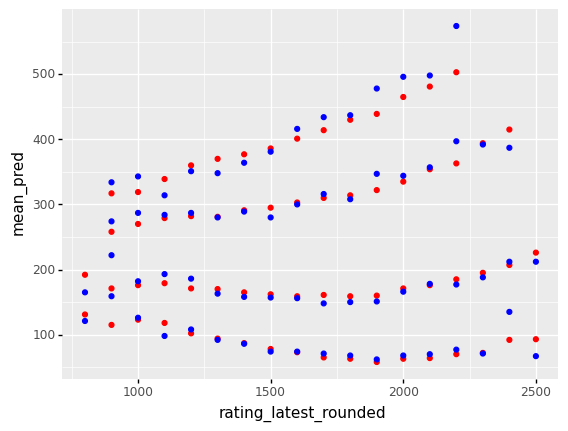

<ggplot: (8766113964162)>

In [67]:
(ggplot(error_summary.query("time_control=='Blitz'&target_rating_gain_rounded<=300")) +
geom_point(aes(x='rating_latest_rounded',y='mean_pred'),color='red')+
 geom_point(aes(x='rating_latest_rounded',y='mean_actual'),color='blue')
)

### Eval for core use cases

In [68]:
# Most users in discord will be rated between 1200-2200...
#... trying to improve between 0-200 rating points...
# in blitz or rapid
# How does the model do with them?
df_cont_core = df_cont.query("target_rating_gain<=200&rating_latest>=1200&rating_latest<=2200")
df_cont_core.groupby("time_control")['abs_error'].describe().round()

,count,mean,std,min,25%,50%,75%,max
time_control,,,,,,,,
Blitz,24327.0,99.0,97.0,0.0,35.0,72.0,125.0,653.0
Bullet,16138.0,93.0,99.0,0.0,32.0,66.0,112.0,697.0
Classical,5842.0,119.0,104.0,0.0,48.0,93.0,150.0,666.0
Rapid,12480.0,130.0,100.0,0.0,58.0,108.0,175.0,699.0


In [69]:
df_cont_small = df_cont.query("target_rating_gain<=75&rating_latest>=1200&rating_latest<=2200")

In [70]:
df_cont_small.groupby("time_control")['abs_error'].describe().round()

,count,mean,std,min,25%,50%,75%,max
time_control,,,,,,,,
Blitz,14071.0,76.0,85.0,0.0,27.0,55.0,92.0,653.0
Bullet,9376.0,78.0,90.0,0.0,27.0,55.0,93.0,697.0
Classical,3748.0,108.0,99.0,0.0,45.0,87.0,129.0,666.0
Rapid,7255.0,120.0,99.0,0.0,55.0,98.0,148.0,699.0


# Scoring

In [156]:
logit.params.head()


Intercept                           4.837646
target_rating_gain                  0.000505
rating_latest                      -0.000805
target_rating_gain:rating_latest   -0.000011
bullet                             -3.803729
dtype: float64

In [157]:
ols.params.head()

Intercept                           326.733432
target_rating_gain                    0.286877
rating_latest                        -0.265619
target_rating_gain:rating_latest      0.000919
bullet                              127.165346
dtype: float64

In [176]:
#model_params=pd.concat([logit.params,ols.params],axis=1).reset_index()
#model_params.columns = ['var_name','logit','ols']
#model_params.to_csv("data/model_params_20210805.csv",index=False)
#model_params.head()

,var_name,logit,ols
0,Intercept,4.837646,326.733432
1,target_rating_gain,0.000505,0.286877
2,rating_latest,-0.000805,-0.265619
3,target_rating_gain:rating_latest,-0.000011,0.000919
4,bullet,-3.803729,127.165346


In [180]:
model_params = pd.read_csv("data/model_params_20210805.csv")
model_params.head()

,var_name,logit,ols
0,Intercept,4.837646,326.733432
1,target_rating_gain,0.000505,0.286877
2,rating_latest,-0.000805,-0.265619
3,target_rating_gain:rating_latest,-0.000011,0.000919
4,bullet,-3.803729,127.165346


In [184]:
# Convert rating history info from JSON to Dataframe
def process_rating_history(response_json):
    rating_history = dict()
    for x in response_json:
            if x['name'] in ['Bullet','Blitz','Rapid','Classical']:
                tbl = pd.DataFrame(x['points'])
                tbl.columns = ['year','month','day','rating']
                tbl['month'] = tbl['month']+1
                tbl['date'] = pd.to_datetime(tbl.year*10000+tbl.month*100+tbl.day,format='%Y%m%d')
                rating_history[x['name']] = tbl
    return(rating_history)

# Get the values that are inputs to the models
def get_predictor_values(rating_history,target_rating,target_time_control):
    target_rating_history = rating_history[target_time_control]
    t_minus_30 = datetime.today()-timedelta(days=30)
    t_minus_90 = datetime.today()-timedelta(days=90)
    t_minus_180 = datetime.today()-timedelta(days=180)
    target_rating_history_30 = target_rating_history.query('date>=@t_minus_30')
    target_rating_history_90 = target_rating_history.query('date>=@t_minus_90')
    target_rating_history_180 = target_rating_history.query('date>=@t_minus_180')    
    rating_latest = target_rating_history['rating'].values[-1]
    target_rating_gain = target_rating-rating_latest
    predictor_values = dict(Intercept=1,target_rating_gain=target_rating_gain,
        target_rating_gain_squared=target_rating_gain**2,
        rating_latest=rating_latest,
        rating_latest_squared = rating_latest**2,
        bullet = int(target_time_control == 'Bullet'), blitz = int(target_time_control == 'Blitz'),
        rapid = int(target_time_control == 'Rapid'), classical = int(target_time_control == 'Classical'),
        rating_peak_diff = rating_latest-target_rating_history['rating'].max(),
        rating_30_diff = rating_latest-target_rating_history_30['rating'].values[0],
        rating_90_diff = rating_latest-target_rating_history_90['rating'].values[0],
        rating_180_diff = rating_latest-target_rating_history_180['rating'].values[0],
        rating_updates_30 = len(target_rating_history_30['rating']),
        rating_updates_90 = len(target_rating_history_90['rating']),
        rating_stdev_30 = target_rating_history_30['rating'].std() if len(target_rating_history_30) > 1 else 0,
        rating_stdev_90 = target_rating_history_90['rating'].std() if len(target_rating_history_90) > 1 else 0
                                   )
    return(predictor_values)

# Calculate the probability of success given a set of predictor values and a classification model
def get_prob_success(predictor_values,model_params):
    logit_params = model_params[['var_name','logit']].dropna()
    linear_combo = 0
    for i in range(len(logit_params)):
        var_name = logit_params['var_name'].values[i]
        coef = logit_params['logit'].values[i]
        if ':' in var_name:
            var_names = var_name.split(":")
            value = 1
            for j in var_names:
                value *= predictor_values[j]
        else:
            value = predictor_values[var_name]
        linear_combo += coef*value
    return str(round(100*1/(1+np.exp(-1*(linear_combo)))))+"%"

# Calculate the predicted days until target rating given a set of predictor values and a regression model
def get_predicted_date(predictor_values,model_params):
    ols_params = model_params[['var_name','ols']].dropna()
    predicted_days = 0
    for i in range(len(ols_params)):
        var_name = ols_params['var_name'].values[i]
        coef = ols_params['ols'].values[i]
        if ':' in var_name:
            var_names = var_name.split(":")
            value = 1
            for j in var_names:
                value *= predictor_values[j]
        else:
            value = predictor_values[var_name]
        predicted_days += coef*value
    predicted_date = (datetime.today()+timedelta(days=predicted_days)).strftime(format="%B %d, %Y")
    return(predicted_date)

# Return the predictions based on discord inputs
def score(username,target_rating,target_time_control,model_params):
    url = f'https://lichess.org/api/user/{username}/rating-history'
    response = requests.get(url)
    response_json = response.json()
    if response.status_code != 200:
        return(f"API ERROR: {response.status_code}")
    else:
        rating_history = process_rating_history(response_json)
        predictor_values = get_predictor_values(rating_history,target_rating,target_time_control)
        #print(predictor_values)
        prob_success = get_prob_success(predictor_values,model_params)
        predicted_date = get_predicted_date(predictor_values,model_params)
        return(prob_success,predicted_date)
score(username = "HumanSponge",target_rating = 1900,
      target_time_control = "Blitz",model_params = model_params)


('95%', 'January 22, 2022')

In [154]:
#df_bin.query("target_rating_gain>100&target_rating_gain<150&time_control=='Rapid'&rating_latest>1850&rating_latest<1900")[['y_bin','prob']].agg([np.mean,len])

In [72]:
#datetime.date(datetime.today()-timedelta(days=90)).strftime(format='%Y-%m-%d')

In [73]:
#target_rating_history.dtypes

## Features
- Target time control (likely interacted with various other features)
- Target rating gain
- Current rating (likely nonlinear relationship)
- Rating growth in last 30 days / 90 days / 180 days
- Rating volatility measures
- Peak historical rating relative to current rating
- Rating in other time controls + puzzles
- Rating growth in other time controls + puzzles
- Difference between other time control ratings + target time control rating
- How long you've been on lichess
- How many games you've played (ever, and within last 30 days, and within the target time control - if you haven't played many it could mean more uncertainty). Consider that most discord bot users will have played more recent rated games in the target time control than the typical user in the training data. 
- Last time you played a rated game in the target time control (if it's a long time ago, it could mean more uncertainty)
- Have you recently been playing puzzles? What about slow games? That could indicate seriousness about improvement

## Outcomes
- Will you ever achieve a rating that's X rating points higher than your current rating in the next Y months (X is calculated from target rating submitted by user, Y = 24?)
- If so, when will you first reach the target rating? (point estimate + prediction interval of dates) - use number of days as outcome, then transform to date for the bot message
- Try to tweak model to avoid negative predictions, and manually override when needed. Same with predictions greater than 2 years out.


## Notes:
- Use cross-validation since sample size might be constrained
- Need to impute nulls
- Need to write code for scoring based on discord input (including lichess API querying)
- Need to figure out how to make prediction interval
- Add more comments + documentation to final version
